## Prepare training data
- make point data in QGIS
- extract_ard_pixels.py
- complete CEO survey
- download ceo sample csv
- rename plot ids
- make_label_arrays
- update plot ids in ceo plot csv
- move to s3
- plantations_ard.sh to generate ARD training data
- sync ARD to laptop
- feature_extraction.ipynb to generate features

In [10]:
#import tensorflow as tf
import os
import hickle as hkl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re 
import sys
sys.path.append('../../src/')
from utils import indices
from utils import quick_viz as viz
from pyproj import Proj, transform
import pandas as pd
import rasterio as rs
import numpy as np
pd.options.mode.copy_on_write = False 

## Make point data in QGIS

In [6]:
## create input csv of random points
# should look something like this with req cols lon, lat, plotid
# could have an assert that looks for these before proceeding
input = pd.read_csv('../../data/train_v20_raw.csv')
input.head()

,LON,LAT,PLOTID
0,-0.894265,6.116738,0
1,-0.873014,6.119955,1
2,-0.889195,6.098315,2
3,-1.337592,5.862637,3
4,-1.597585,5.791188,4


## Extract ARD pixels

In [7]:
# docker container for generating ARD requires plot level survey

local_folder = ("/data/tof-output-2022/")
train_df = ".csv" # input csv
output_df = f"{train_df[:-4]}_ard.csv"

def image_latlon_pxpy(local_folder, X, Y, latitude, longitude):
    X = str(X)
    Y = str(Y)
    fname = f"{local_folder}/{X}/{Y}/{X}X{Y}Y_FINAL.tif"
    dataset = rs.open(fname)
    px = longitude
    py = latitude
    px_pc = (px - dataset.bounds.left) / (dataset.bounds.right - dataset.bounds.left)
    py_pc = (dataset.bounds.top - py) / (dataset.bounds.top - dataset.bounds.bottom)
    return (np.floor(px_pc*dataset.width), np.floor(py_pc*dataset.height)), dataset.height, dataset.width

def check_ard_availability(train_df, output_df):
    '''
    Given a plot level CEO csv (one row per plot), identifies where ARD is not available.
    Identifies available data by calculating whether plot centroids are 
    >16 pixels away from a TTC tile edge.
    Requires TTC final tifs to be stored locally for image_latlon_pxpy()
    The output csv contains new columns X_tile and Y_tile which indicate
    the TTC tile id. Where the row contains 0 are areas where ARD is not
    available. 
    TODO: output file should drop rows where ARD not available.
    '''
    train_df = pd.read_csv(train_df)
    deploy_df = pd.read_csv("../data/america-africa-europe.csv") # TTC tile grid
    
    train_df['X_tile'] = 0
    train_df['Y_tile'] = 0
    train_df['X_px'] = 0
    train_df['Y_px'] = 0
    train_df['X'] = 0.
    train_df['Y'] = 0.
    
    deploy_lons = deploy_df.X
    deploy_lats = deploy_df.Y
    
    for i, val in train_df.iterrows():
        try:
            lon = val.lon
            lat = val.lat
            x_tile = np.argmin(abs(lon - deploy_lons))
            lon_tile = deploy_df.X[x_tile]
            x_tile = deploy_df.X_tile[x_tile]
            
            y_tile = np.argmin(abs(lat - deploy_lats))
            lat_tile = deploy_df.Y[y_tile]
            y_tile = deploy_df.Y_tile[y_tile]
            l, w, h = image_latlon_pxpy(local_folder, x_tile, y_tile, lat, lon)
            if l[0] > 16 and l[1] > 16:
                if l[0] < (w - 16) and l[1] < (h - 16): 
                    train_df.iloc[i, train_df.columns.get_loc('X_tile')] = x_tile
                    train_df.iloc[i, train_df.columns.get_loc('Y_tile')] = y_tile
    
                    train_df.iloc[i, train_df.columns.get_loc('X')] = lon_tile
                    train_df.iloc[i, train_df.columns.get_loc('Y')] = lat_tile
    
                    train_df.iloc[i, train_df.columns.get_loc('X_px')] = l[0]
                    train_df.iloc[i, train_df.columns.get_loc('Y_px')] = l[1]
        except:
            continue
    # TODO: drop rows where ARD not available
    # add column for country
    train_df.to_csv(output_df, index = False)
    
    return None

In [12]:

# the output of extract ard pixels looks like this
df = pd.read_csv('../../data/ceo-plantations-train-v21_ard.csv')
df.head(10)

,plot_id,plot_fname,long,lat,X_tile,Y_tile,X_px,Y_px,X,Y,country
0,0,21000,-0.296287,11.047547,1680,1162,404,89,-0.3056,11.0278,Ghana
1,1,21001,-0.296397,11.043931,1680,1162,403,129,-0.3056,11.0278,Ghana
2,2,21002,-0.063961,11.037859,1684,1162,513,197,-0.0833,11.0278,Ghana
3,3,21003,-0.072542,11.038813,1684,1162,420,186,-0.0833,11.0278,Ghana
4,4,21004,-0.198590,11.015392,1682,1162,257,447,-0.1944,11.0278,Ghana
5,5,21005,-0.195594,11.015228,1682,1162,289,448,-0.1944,11.0278,Ghana
6,6,21006,-0.300874,11.017021,1680,1162,354,428,-0.3056,11.0278,Ghana
7,7,21007,-0.294151,11.003914,1680,1162,427,574,-0.3056,11.0278,Ghana
8,8,21008,-0.292840,10.996686,1680,1161,441,36,-0.3056,10.9722,Ghana
9,9,21009,-1.475804,10.838375,1659,1159,263,561,-1.4722,10.8611,Ghana


In [13]:
# this needs to be at the pixel level
df2 = pd.read_csv('../../data/ceo-plantations-train-v20.csv')
df2.head(10)

,index,PLOT_ID,SAMPLE_ID,LON,LAT,EMAIL,FLAGGED,COLLECTION_TIME,ANALYSIS_DURATION,IMAGERY_TITLE,IMAGERY_ATTRIBUTIONS,SAMPLE_GEOM,SYSTEM,PLOT_FNAME,PLANTATION
0,0,0,-195,-0.894849,6.116158,jessica.ertel@wri.org,False,2023-06-28 19:26,98.8 secs,Mapbox Satellite,NaN,POINT(-0.894848875934758 6.116157612001956),Unknown,20001,255
1,1,0,-194,-0.894849,6.116247,jessica.ertel@wri.org,False,2023-06-28 19:26,98.8 secs,Mapbox Satellite,NaN,POINT(-0.894848875934758 6.116246932196532),Unknown,20001,255
2,2,0,-193,-0.894849,6.116336,jessica.ertel@wri.org,False,2023-06-28 19:26,98.8 secs,Mapbox Satellite,NaN,POINT(-0.894848875934758 6.116336252376186),Unknown,20001,255
3,3,0,-192,-0.894849,6.116426,jessica.ertel@wri.org,False,2023-06-28 19:26,98.8 secs,Mapbox Satellite,NaN,POINT(-0.894848875934758 6.116425572540933),Unknown,20001,255
4,4,0,-191,-0.894849,6.116515,jessica.ertel@wri.org,False,2023-06-28 19:26,98.8 secs,Mapbox Satellite,NaN,POINT(-0.894848875934758 6.116514892690745),Unknown,20001,255
5,5,0,-190,-0.894849,6.116604,jessica.ertel@wri.org,False,2023-06-28 19:26,98.8 secs,Mapbox Satellite,NaN,POINT(-0.894848875934758 6.116604212825635),Unknown,20001,255
6,6,0,-189,-0.894849,6.116694,jessica.ertel@wri.org,False,2023-06-28 19:26,98.8 secs,Mapbox Satellite,NaN,POINT(-0.894848875934758 6.116693532945618),Unknown,20001,255
7,7,0,-188,-0.894849,6.116783,jessica.ertel@wri.org,False,2023-06-28 19:26,98.8 secs,Mapbox Satellite,NaN,POINT(-0.894848875934758 6.116782853050665),Unknown,20001,255
8,8,0,-187,-0.894849,6.116872,jessica.ertel@wri.org,False,2023-06-28 19:26,98.8 secs,Mapbox Satellite,NaN,POINT(-0.894848875934758 6.116872173140791),Unknown,20001,255
9,9,0,-186,-0.894849,6.116961,jessica.ertel@wri.org,False,2023-06-28 19:26,98.8 secs,Mapbox Satellite,NaN,POINT(-0.894848875934758 6.11696149321601),Unknown,20001,255


In [15]:
df = pd.read_csv(f'../../data/ceo-plantations-train-v21-sample-data.csv')
df.head()

,plotid,sampleid,lon,lat,email,flagged,collection_time,analysis_duration,imagery_title,imagery_attributions,sample_geom,pl_area,pl_perimeter,pl_reserve_na,System
0,0,-195,-0.296882,11.046963,jessica.ertel@wri.org,False,2024-01-25 16:05,5.4 secs,Mapbox Satellite,NaN,POINT(-0.296882249875727 11.046962764482586),2366270.0,2366270.0,Zawsi,Not plantation
1,0,-194,-0.296882,11.047053,jessica.ertel@wri.org,False,2024-01-25 16:05,5.4 secs,Mapbox Satellite,NaN,POINT(-0.296882249875727 11.047052596176258),2366270.0,2366270.0,Zawsi,Not plantation
2,0,-193,-0.296882,11.047142,jessica.ertel@wri.org,False,2024-01-25 16:05,5.4 secs,Mapbox Satellite,NaN,POINT(-0.296882249875727 11.047142427842445),2366270.0,2366270.0,Zawsi,Not plantation
3,0,-192,-0.296882,11.047232,jessica.ertel@wri.org,False,2024-01-25 16:05,5.4 secs,Mapbox Satellite,NaN,POINT(-0.296882249875727 11.047232259481163),2366270.0,2366270.0,Zawsi,Not plantation
4,0,-191,-0.296882,11.047322,jessica.ertel@wri.org,False,2024-01-25 16:05,5.4 secs,Mapbox Satellite,NaN,POINT(-0.296882249875727 11.047322091092326),2366270.0,2366270.0,Zawsi,Not plantation


In [16]:
df = pd.read_csv(f'../../data/ceo-plantations-train-v22-sample-data.csv')
df.head()

,plotid,sampleid,lon,lat,email,flagged,collection_time,analysis_duration,imagery_title,imagery_attributions,sample_geom,pl_land_use,pl_dominant,pl_district,System
0,0,-195,-0.296378,6.871327,jessica.ertel@wri.org,False,2024-01-26 16:02,276.3 secs,Mapbox Satellite,NaN,POINT(-0.296378129990519 6.871327094704924),cropland,mango,afram plains north south,Monoculture
1,0,-194,-0.296378,6.871417,jessica.ertel@wri.org,False,2024-01-26 16:02,276.3 secs,Mapbox Satellite,NaN,POINT(-0.296378129990519 6.87141692633547),cropland,mango,afram plains north south,Monoculture
2,0,-193,-0.296378,6.871507,jessica.ertel@wri.org,False,2024-01-26 16:02,276.3 secs,Mapbox Satellite,NaN,POINT(-0.296378129990519 6.871506757949007),cropland,mango,afram plains north south,Monoculture
3,0,-192,-0.296378,6.871597,jessica.ertel@wri.org,False,2024-01-26 16:02,276.3 secs,Mapbox Satellite,NaN,POINT(-0.296378129990519 6.871596589545618),cropland,mango,afram plains north south,Monoculture
4,0,-191,-0.296378,6.871686,jessica.ertel@wri.org,False,2024-01-26 16:02,276.3 secs,Mapbox Satellite,NaN,POINT(-0.296378129990519 6.871686421125233),cropland,mango,afram plains north south,Monoculture


In [41]:
## step to add individual plot names based on ceo survey

def clean_df_plotids(ceo_version):
    '''
    Perform simple clean up of columns
    and creates a unique plot fname using the
    ceo version ex: 08001, 08002

    This requires the labeled sample csv from collect earth
    '''
    csv_path = (f'../../data/ceo-plantations-train-v{ceo_version}-sample-data.csv')
    out_path = (f'../../data/ceo-plantations-train-v{ceo_version}.csv')
    df = pd.read_csv(csv_path, encoding = "ISO-8859-1")
    df.columns = [re.sub(r'\W+', '', x) for x in df.columns]
    df.rename(columns={'ïplotid':'plotid'}, inplace=True)
    df.columns = [x.upper() for x in df.columns]
    df.columns = ['PLOT_ID' if x == 'PLOTID' else x for x in df.columns]
    df.columns = ['SAMPLE_ID' if x == 'SAMPLEID' else x for x in df.columns]
    
    # create a col for plot fname and plantation labels
    df['PLOT_FNAME'] = '0' 
    df['PLANTATION'] = df.SYSTEM.map({'Not plantation': 0, 
                                    'Monoculture': 1,
                                    'Agroforestry': 2,
                                    'Unknown': 255})
    if len(df) > 0:
        plot_ids = []
        counter = 0
        for index, row in df.iterrows():
            if row['PLOT_ID'] not in plot_ids:
                plot_ids.append(row['PLOT_ID'])
                counter += 1
            df['PLOT_FNAME'][index] = f"{str(ceo_version).zfill(2)}{str(counter).zfill(3)}"

    # this drops all other columns and nulls values
    # and creates a list of plot Ids
    # TODO -- determine if this step is needed
    keep_columns = ['PLOT_ID', 'SAMPLE_ID', 'LON', 'LAT', 'PLANTATION', 'PLOT_FNAME'] 
    for column in df.columns:
        if column not in keep_columns:
            df = df.drop(column, axis = 1)
    df = df.dropna(axis = 0)
    print("WRITING CSV...")
    df.to_csv(out_path, index = False)
    
    return df
    
def reconstruct_images(df, plot):
    '''
    Takes a plot ID and subsets the input pd.DataFrame to that plot ID
       returns a (14, 14) array-like list with plantation label
       
        Parameters:
          batch_ids (list):
          batch_size (int):
          
         Returns:
          x_batch (arr):
          y_batch (arr):
    '''
    subs = df[df['PLOT_ID'] == plot]
    rows = []

    # reversed() computes the reverse of a given sequence 
    # object and returns it in the form of a list.
    # method for getting lat column as a list?
    lats = reversed(sorted(subs['LAT'].unique()))

    for i, val in enumerate(lats):

        # filter to row
        subs_lat = subs[subs['LAT'] == val]
        subs_lat = subs_lat.sort_values('LON', axis = 0)
        if 'PLANTATION' in df.columns:
            #print(list(subs_lat['PLANTATION']))
            rows.append(list(subs_lat['PLANTATION']))

    return rows

def create_label_arrays(ceo_version, output_folder='../../data/train-labels/'):
    '''
    creates a label array for each plot in the 
    ceo survey
    '''
    df = clean_df_plotids(ceo_version)
    plot_ids = sorted(df['PLOT_ID'].unique())
    plot_fname = sorted(df['PLOT_FNAME'].unique())
    print('Creating label arrays')
    for i, x in zip(plot_ids, plot_fname):
        #assert x - 8000 == i, print(x, i)
        plot = reconstruct_images(df, i)
        plot = np.array(plot)
        np.save(f"{output_folder}{str(x).zfill(5)}.npy", plot)

    return None

In [40]:
create_label_arrays(22)

/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_31128/2993261352.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PLOT_FNAME'][index] = f"{str(ceo_version).zfill(2)}{str(counter).zfill(3)}"


WRITING CSV...


<AxesSubplot: >

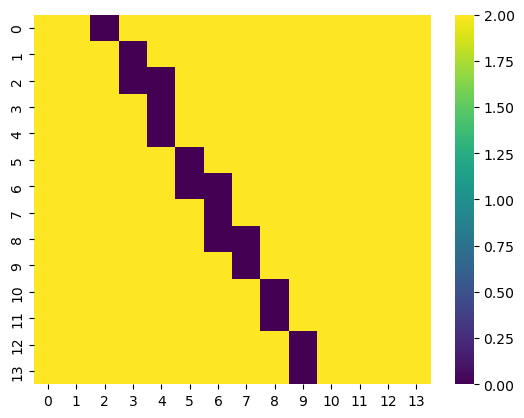

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
img = np.load('../../data/train-labels/22244.npy')
sns.heatmap(img, cmap = sns.color_palette("viridis", as_cmap=True)) 

In [ ]:
# sync label arrays and ceo csv to s3
# s3://restoration-monitoring/plantation-mapping/data/train/train-csv/

In [ ]:
# generate ARD training data
# bash plantations_train_job.sh where the arguments are passed
# bash plantations_train_job.sh 0 250 Ghana 2020 'csv_path.csv' 

In [ ]:
# create features

In [51]:
def preprocess_ard_sample(ard_sample):
    '''
    Calculates remote sensing indices from ARD sample
    and performs scaling. Mins and maxs are provided.
    '''
    min_all = [0.006576638437476157, 0.0162050812542916, 0.010040436408026246, 0.013351644159609368, 
           0.01965362020294499, 0.014229037918669413, 0.015289539940489814, 0.011993591210803388, 
           0.008239871824216068, 0.006546120393682765, 0.0, 0.0, 0.0, -0.1409399364817101,
           -0.4973397113668104, -0.09731556326714398, -0.7193834232943873]

    max_all = [0.2691233691920348, 0.3740291447318227, 0.5171435111009385, 0.6027466239414053, 
           0.5650263218127718, 0.5747005416952773, 0.5933928435187305, 0.6034943160143434,
           0.7472037842374304, 0.7000076295109483, 0.509269855802243, 0.948334642387533, 
           0.6729257769285485, 0.8177635298774327, 0.35768999002433816, 0.7545951919107605, 0.7602693339366691]

    med = np.median(ard_sample, axis = 0)
    med = med[np.newaxis, :, :, :]
    ard_sample = np.concatenate([ard_sample, med], axis = 0)

    # UPDATE -- added calculation of RS indices here
    # previously not included causing shape mismatch
    sample = np.zeros((13, 28, 28, 17))
    sample[..., :13] = ard_sample
    sample[..., 13] = indices.evi(ard_sample)
    sample[..., 14] = indices.bi(ard_sample)
    sample[..., 15] = indices.msavi2(ard_sample)
    sample[..., 16] = indices.grndvi(ard_sample)
    
    for band in range(0, sample.shape[-1]):
        mins = min_all[band]
        maxs = max_all[band]
        sample[..., band] = np.clip(sample[..., band], mins, maxs)
        midrange = (maxs + mins) / 2
        rng = maxs - mins
        standardized = (sample[..., band] - midrange) / (rng / 2)
        sample[..., band] = standardized
    
    return sample

def extract_feats(sample, predict_sess):
    '''
    performs feature extraction for a given sample
    and creates a new array of ttc features with shape
    (14, 14, 65)
    '''
    
    batch_x = sample[np.newaxis]       
    lengths = np.full((batch_x.shape[0]), 12)

    preds = predict_sess.run(predict_logits,
                             feed_dict={predict_inp:batch_x, 
                                        predict_length:lengths})

    inp_features = predict_sess.run(feature_extraction,
                          feed_dict={predict_inp:batch_x, 
                                     predict_length:lengths})

    out_features = predict_sess.run(feature_extraction_initial,
                          feed_dict={predict_inp:batch_x, 
                                     predict_length:lengths})

    all_features = np.empty((14, 14, 1+32+32))
    all_features[..., 0] = preds.squeeze()
    all_features[..., 1:33] = inp_features.squeeze()
    all_features[..., 33:] = out_features.squeeze()[7:-7, 7:-7]
    return all_features 
    
def generate_ttc_features(ceo_version, predict_model_path, input_path, output_path = '../data/ard-features/'):
    '''
    Uses the imported model to extract TTC features for 
    '''

    ## UPDATED - removed 'predict/' from all tensors bc of key error
    predict_graph_def = tf.compat.v1.GraphDef()
    if os.path.exists(predict_model_path):
        print(f"Loading model at {predict_model_path}")
        predict_file = tf.io.gfile.GFile(predict_model_path, 'rb')
        predict_graph_def.ParseFromString(predict_file.read())
        predict_graph = tf.import_graph_def(predict_graph_def, name='predict')
        predict_sess = tf.compat.v1.Session(graph=predict_graph)
        predict_logits = predict_sess.graph.get_tensor_by_name(f"conv2d_13/Sigmoid:0") 
        feature_extraction = predict_sess.graph.get_tensor_by_name(f"csse_out_mul/mul:0")  
        feature_extraction_initial = predict_sess.graph.get_tensor_by_name(
            "gru_drop/drop_block2d/cond/Merge:0")
        predict_inp = predict_sess.graph.get_tensor_by_name("Placeholder:0")
        predict_length = predict_sess.graph.get_tensor_by_name("PlaceholderWithDefault:0")
    else:
        raise Exception(f"The model path {predict_model_path} does not exist")
    
    # UPDATE - pad idx with leading zero here rather than waiting until output is saved
    samps = [int(x[:-4]) for x in os.listdir(f"{input_path}/") if '.npy' in x]
    print(samps)
    samps = [str(x).zfill(5) if len(str(x)) < 5 else str(x) for x in samps]
    print(f"Extracting features for {len(samps)} samples")
    
    
    # for idx in samps:
    #     ard = np.load(f"{input_path}/" + idx + ".npy")
    #     sample = preprocess_ard_sample(ard)
        
    #     if np.prod(sample.shape[:3]) == 13 * 28 * 28:
    #         all_features = extract_feats(sample, predict_sess)
            
    #         hkl.dump(all_features, 
    #                  f"{output_path}/{str(idx).zfill(5)}.hkl", 
    #                  mode='w', 
    #                  compression='gzip'
    #                 )
    #         print(f"{idx} Complete")
    return None

In [54]:
# generate_ttc_features(ceo_version = 21,
#                       predict_model_path = "../models/predict_graph.pb",
#                           input_path = '../data/train-ard/',
#                           output_path = '../data/ard-features/')